In [72]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting Started with Claude 3 Models
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>                                                                                               <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

### Claude on Vertex AI

Anthropic Claude 3 models on Vertex AI offer fully managed and serverless models are offered as managed APIs. To use a Claude model on Vertex AI, send a request directly to the Vertex AI API endpoint.

You can stream your Claude responses to reduce the end-user latency perception. A streamed response uses server-sent events (SSE) to incrementally stream the response.

### Available Anthropic Claude models

#### Claude 3 Sonnet
Anthropic Claude 3 Sonnet provides a balance between intelligence and speed for enterprise workloads. It's a high-endurance model for scaled AI that's available at a competitive price.

#### Claude 3 Haiku
Anthropic Claude 3 Haiku is the fastest, most compact model available from Anthropic. It is designed to answer simple queries and requests quickly. You can use it to build AI experiences that mimic human interactions.

All Claude 3 models can process images and return text outputs, and feature a 200K context window.

## Objective

This notebook shows how to use **Vertex AI API** and **Anthropic’s Vertex SDK for Python** to call the Claude on Vertex AI API with the Claude 3 Sonnet and Claude 3 Haiku model.

For more information, see the [Use Claude](https://cloud.devsite.corp.google.com/vertex-ai/generative-ai/docs/third-party-models/use-claude) documentation.


## Vertex AI API

### Getting Started


#### Select Claude 3 model

In [73]:
MODEL = "claude-3-sonnet@20240229"  # @param ["claude-3-sonnet@20240229", "claude-3-haiku@20240307"]
if MODEL == "claude-3-sonnet@20240229":
    available_regions = ["us-central1", "asia-southeast1"]
else:
    available_regions = ["us-central1", "europe-west4"]

#### Select a region

In [74]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(
    options=available_regions,
    description="Select a region:",
    font_weight="bold",
    style={"description_width": "initial"},
)


def dropdown_eventhandler(change):
    global REGION
    if change["type"] == "change" and change["name"] == "value":
        REGION = change.new
        print("Selected:", change.new)


REGION = dropdown.value
dropdown.observe(dropdown_eventhandler, names="value")
display(dropdown)

Dropdown(description='Select a region:', options=('us-central1', 'asia-southeast1'), style=DescriptionStyle(de…

#### Define Google Cloud project and model information

In [75]:
# Initialize Vertex AI
import vertexai

PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
ENDPOINT = f"https://{REGION}-aiplatform.googleapis.com"

if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    raise ValueError("Please set your PROJECT_ID")
vertexai.init(project=PROJECT_ID, location=REGION)

#### Authenticate your notebook environment (Colab only)
If you are running this notebook on Google Colab, uncomment and run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [76]:
# from google.colab import auth
# auth.authenticate_user(project_id=PROJECT_ID)

#### Import required module

In [77]:
import json

### Text generation

#### Unary call

In [78]:
PAYLOAD = {
    "anthropic_version": "vertex-2023-10-16",
    "messages": [{"role": "user", "content": "Send me a recipe for banana bread."}],
    "max_tokens": 100,
    "stream": False,
}

request = json.dumps(PAYLOAD)
!curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json" {ENDPOINT}/v1/projects/{PROJECT_ID}/locations/{REGION}/publishers/anthropic/models/{MODEL}:rawPredict -d '{request}'

{"id":"msg_0153aSPECsnuvUAVx3DMWnHA","type":"message","role":"assistant","content":[{"type":"text","text":"Here is a classic recipe for delicious banana bread:\n\nBanana Bread\n\nIngredients:\n- 1 3/4 cups (220g) all-purpose flour\n- 1 teaspoon baking soda\n- 1/4 teaspoon salt\n- 1/2 cup (115g) unsalted butter, at room temperature\n- 3/4 cup (165g) granulated sugar\n- 2"}],"model":"claude-3-sonnet-20240229","stop_reason":"max_tokens","stop_sequence":null,"usage":{"input_tokens":15,"output_tokens":100}}

#### Streaming call

In [79]:
PAYLOAD = {
    "anthropic_version": "vertex-2023-10-16",
    "messages": [{"role": "user", "content": "Send me a recipe for banana bread."}],
    "max_tokens": 100,
    "stream": True,
}

request = json.dumps(PAYLOAD)
!curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json" {ENDPOINT}/v1/projects/{PROJECT_ID}/locations/{REGION}/publishers/anthropic/models/{MODEL}:streamRawPredict -d '{request}'

event: message_start
data: {"type":"message_start","message":{"id":"msg_01BAYDzHALPYQoV74iHB2gFj","type":"message","role":"assistant","content":[],"model":"claude-3-sonnet-20240229","stop_reason":null,"stop_sequence":null,"usage":{"input_tokens":15,"output_tokens":1}}             }

event: ping
data: {"type": "ping"}

event: content_block_start
data: {"type":"content_block_start","index":0,"content_block":{"type":"text","text":""}               }

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":"Here"}           }

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" is"}}

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" a"}         }

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" classic"}        }

event: content_block_delta
data: {"type":"c

### Vision

#### Encode And Preview Image

We'll fetch sample images from Wikipedia using the httpx library, but you can use whatever image sources work for you.

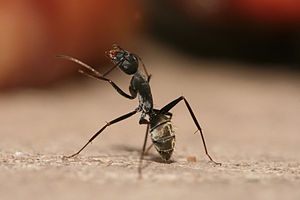

In [80]:
import base64

import httpx
import requests
from IPython.display import Image

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Camponotus_flavomarginatus_ant.jpg/300px-Camponotus_flavomarginatus_ant.jpg"
image_b64 = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

response = requests.get(image_url)
image = Image(response.content, width=300, height=200)

image

#### Unary call

In [81]:
PAYLOAD = {
    "anthropic_version": "vertex-2023-10-16",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "What is in this image?"},
            ],
        }
    ],
    "max_tokens": 100,
    "stream": False,
}

request = json.dumps(PAYLOAD)
!curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json" {ENDPOINT}/v1/projects/{PROJECT_ID}/locations/{REGION}/publishers/anthropic/models/{MODEL}:rawPredict -d '{request}'

{"id":"msg_012bz3acSU2qqcf32QRfGEuM","type":"message","role":"assistant","content":[{"type":"text","text":"This image shows an extremely close-up view of an ant. The ant appears to be carrying something, likely food or prey, with its mandibles (mouthparts). The ant has a distinct body segmented into the head, thorax, and abdomen, which is typical of insects. The ant's legs and antennae are clearly visible. The background is slightly blurred, allowing the tiny ant to be the sharp focus of the image, showcasing intricate details of this small"}],"model":"claude-3-sonnet-20240229","stop_reason":"max_tokens","stop_sequence":null,"usage":{"input_tokens":134,"output_tokens":100}}

#### Streaming call

In [82]:
PAYLOAD = {
    "anthropic_version": "vertex-2023-10-16",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "What is in this image?"},
            ],
        }
    ],
    "max_tokens": 100,
    "stream": True,
}

request = json.dumps(PAYLOAD)
!curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json" {ENDPOINT}/v1/projects/{PROJECT_ID}/locations/{REGION}/publishers/anthropic/models/{MODEL}:streamRawPredict -d '{request}'

event: message_start
data: {"type":"message_start","message":{"id":"msg_01WPNNzXsNCQmtKkT1aqMriX","type":"message","role":"assistant","content":[],"model":"claude-3-sonnet-20240229","stop_reason":null,"stop_sequence":null,"usage":{"input_tokens":134,"output_tokens":1}}             }

event: ping
data: {"type": "ping"}

event: content_block_start
data: {"type":"content_block_start","index":0,"content_block":{"type":"text","text":""}         }

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":"This"}       }

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" image"}          }

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" shows"}            }

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" a"}}

event: content_block_delta
data: {"type":"cont

## Using Anthropic's Vertex SDK for *Python*

### Getting Started


#### Install Anthropic's Vertex SDK for Python

In [83]:
! pip3 install -U 'anthropic[vertex]'

#### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [84]:
# Restart kernel after installs so that your environment can access the new packages
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

#### Select Claude 3 model

In [85]:
MODEL = "claude-3-sonnet@20240229"  # @param ["claude-3-sonnet@20240229", "claude-3-haiku@20240307"]
if MODEL == "claude-3-sonnet@20240229":
    available_regions = ["us-central1", "asia-southeast1"]
else:
    available_regions = ["us-central1", "europe-west4"]

#### Select a region

In [86]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(
    options=available_regions,
    description="Select a region:",
    font_weight="bold",
    style={"description_width": "initial"},
)


def dropdown_eventhandler(change):
    global REGION
    if change["type"] == "change" and change["name"] == "value":
        REGION = change.new
        print("Selected:", change.new)


REGION = dropdown.value
dropdown.observe(dropdown_eventhandler, names="value")
display(dropdown)

Dropdown(description='Select a region:', options=('us-central1', 'asia-southeast1'), style=DescriptionStyle(de…

#### Define Google Cloud project and model information

In [87]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
ENDPOINT = f"https://{REGION}-aiplatform.googleapis.com"

if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    raise ValueError("Please set your PROJECT_ID")

#### Authenticate your notebook environment
If you are running this notebook on Google Colab, uncomment run the following cell to authenticate your environment.

Note: To authenticate for the SDK, you must provide `project_id` parameter. See the example command below.

In [88]:
# from google.colab import auth
# auth.authenticate_user(project_id=PROJECT_ID)

### Text generation

#### Unary call

In [89]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region=REGION, project_id=PROJECT_ID)
message = client.messages.create(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": "Send me a recipe for banana bread.",
        }
    ],
    model=MODEL,
)
print(message.model_dump_json(indent=2))

{
  "id": "msg_01LfuY8ZNqePDDoeZVNEy7Y5",
  "content": [
    {
      "text": "Here is a classic recipe for delicious banana bread:\n\nBanana Bread\n\nIngredients:\n- 1 3/4 cups (220g) all-purpose flour\n- 1 teaspoon baking soda\n- 1/4 teaspoon salt\n- 1/2 cup (115g) unsalted butter, softened\n- 3/4 cup (150g) granulated sugar\n- 2 large eggs\n- 1 teaspoon vanilla extract\n- 1 1/4 cups (300g) mashed ripe bananas (about 3 medium bananas)\n\nInstructions:\n\n1. Preheat oven to 350°F (177°C). Grease a 9x5 inch loaf pan and set aside.\n\n2. In a medium bowl, whisk together the flour, baking soda and salt. Set aside.\n\n3. In a large bowl, beat the butter and sugar together until light and fluffy, about 2-3 minutes. Beat in the eggs one at a time, then the vanilla extract. \n\n4. Stir the dry ingredients into the wet ingredients alternately with the mashed bananas, mixing just until combined after each addition. \n\n5. Pour the batter into the prepared loaf pan and smooth the top with a rubb

#### Streaming call

In [90]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region="us-central1", project_id=PROJECT_ID)

with client.messages.stream(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": "Send me a recipe for banana bread.",
        }
    ],
    model=MODEL,
) as stream:
    for text in stream.text_stream:
        print(text, end="", flush=True)

Here is a classic recipe for delicious banana bread:

Banana Bread

Ingredients:
- 1 3/4 cups (220g) all-purpose flour
- 1 teaspoon baking soda
- 1/4 teaspoon salt
- 1/2 cup (115g) unsalted butter, softened
- 3/4 cup (150g) granulated sugar
- 2 large eggs
- 1 1/2 cups (340g) mashed ripe bananas (about 3-4 medium bananas)
- 1/3 cup (80ml) milk or buttermilk
- 1 teaspoon vanilla extract
- 1/2 cup (65g) chopped nuts like walnuts or pecans (optional)

Instructions:

1. Preheat oven to 350°F (177°C). Grease a 9x5 inch loaf pan and set aside.

2. In a medium bowl, whisk together the flour, baking soda and salt. Set aside.

3. In a large bowl, beat the butter and sugar together until light and fluffy, about 2-3 minutes. Beat in the eggs one at a time, then stir in the mashed bananas, milk and vanilla. 

4. Fold in the dry ingredients just until combined, being careful not to over mix. Fold in nuts if using.

5. Pour batter into prepared loaf pan and bake for 55-65 minutes, until a toothpick i

### Vision

#### Encode And Preview Image

We'll fetch sample images from Wikipedia using the httpx library, but you can use whatever image sources work for you.

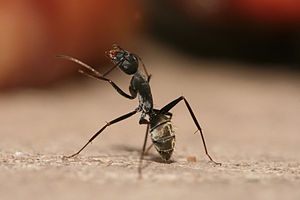

In [91]:
import base64

import httpx
import requests
from IPython.display import Image

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Camponotus_flavomarginatus_ant.jpg/300px-Camponotus_flavomarginatus_ant.jpg"
image_media_type = "image/jpeg"
image_b64 = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

response = requests.get(image_url)
image = Image(response.content, width=300, height=200)

image

#### Unary call

In [92]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region=REGION, project_id=PROJECT_ID)

message = client.messages.create(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image_media_type,
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "Describe this image."},
            ],
        }
    ],
    model=MODEL,
)
print(message.model_dump_json(indent=2))

{
  "id": "msg_01XuGaorLeDuyXnJhXDiX5N2",
  "content": [
    {
      "text": "The image shows a close-up view of an ant. The ant appears to be a black ant or carpenter ant species. It has a distinct body segmentation with a thin waist between the thorax and abdomen, which is characteristic of ants. The ant has six legs and two antennae protruding from its head. The detail and focus of the image allow you to clearly see the intricate structure and features of this small insect. The ant is positioned on a sandy or light-colored surface, creating a nice contrast that highlights its form. The background is slightly out of focus, drawing the viewer's attention to the sharp, detailed ant in the foreground.",
      "type": "text"
    }
  ],
  "model": "claude-3-sonnet-20240229",
  "role": "assistant",
  "stop_reason": "end_turn",
  "stop_sequence": null,
  "type": "message",
  "usage": {
    "input_tokens": 133,
    "output_tokens": 142
  }
}


#### Streaming call

In [93]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region=REGION, project_id=PROJECT_ID)

with client.messages.stream(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image_media_type,
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "Describe this image."},
            ],
        }
    ],
    model=MODEL,
) as stream:
    for text in stream.text_stream:
        print(text, end="", flush=True)

The image shows an extremely close-up view of an ant. The ant appears to be a black or dark-colored species. It has a distinctively shaped head, with large mandibles or pincers that are open wide. The ant's body segments and six legs are clearly visible, giving detailed insight into its intricate anatomy and structure. The ant is walking on what seems to be a light-colored, gritty surface like concrete or sand. The background is slightly blurred, allowing the ant to be the sharp focus, making this an exquisitely detailed and captivating macro photograph of this tiny creature.